# Deep Neural Network: Implementation and Image Classification
## Cat or not a cat: part II

The purpose of this notebook is to apply a neural network with L layers to the data used in the `logistic_regression` notebook, trying to improve the accuracy of its classification. It also uses notation previously explained in the `shallow_neural_network` notebook.

In [24]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

## Part I: building a deep neural network

We will implement auxiliary functions that will ease the implementation of the model functions. In Part II, we will use these functions to build a 2 layer and an L layer neural network.

#### 1. Activation functions

We will use a ReLU function for the first $L-1$ layers and a sigmoid function for the last one (since we need a result between $0$ and $1$). If $g$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) \tag{11}$$.  

In [25]:
def sigmoid(Z):
    sigm = 1 / (1 + np.exp(-Z))
    return (sigm, Z)

def relu(Z):
    rel = np.maximum(0, Z)
    return (rel, Z)

def sigmoid_backward(dA, cache):
    Z = cache 
    sigm = 1 / (1 + np.exp(-Z))
    dZ = dA * sigm * (1 - sigm)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

#### 2. Initializing the parameters

We initiate the weights randomly and the biases with $0$. For the deep neural network, we use the array layer_dims, in which we store the number of units in each layer of the network.

In [26]:
#2 layer NN
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

#L layer NN
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            #number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

#### 3 Forward propagation
##### a. Linear forward 
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}, \qquad A^{[0]} = X$$

In [27]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)    #store cache for the backward propagation
    
    return Z, cache

##### b. Linear activation forward

$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation $g$ can be sigmoid() or relu()

In [28]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

##### c. Linear activation forward for deep NN

When implementing the $L$ layer Neural Network, we will use ReLU $L-1$ times and sigmoid once.

$A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$

In [29]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  #number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

#### 4. Cost function

The cost function has the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$


In [30]:
def compute_cost(AL, Y):
    m = Y.shape[1]    #number of examples
    cost = - (1 / m) * np.sum(np.dot(Y, np.log(AL).T) + np.dot(1 - Y, np.log(1 - AL).T))
    cost = np.squeeze(cost)
    return cost

#### 5. Backward propagation

##### a. Linear backward

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$


In [31]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

##### b. Linear activation backward 

In [32]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

##### c. Linear activation backward for deep NN

In [33]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)         #number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

#### Updating parameters

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where $\alpha$ is the learning rate

In [34]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2     #number of layers

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

## Part II: Image Classification

In [35]:
# Loading and modifying the data
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    initial_train_set_x = np.array(train_dataset["train_set_x"][:])  
    train_set_y = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    initial_test_set_x = np.array(test_dataset["test_set_x"][:])       
    test_set_y = np.array(test_dataset["test_set_y"][:])

    train_set_x = initial_train_set_x.reshape(initial_train_set_x.shape[0], -1).T / 255
    test_set_x = initial_test_set_x.reshape(initial_test_set_x.shape[0], -1).T / 255
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0])) 
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0])) 
    
    return initial_test_set_x, initial_train_set_x, train_set_x, train_set_y, test_set_x, test_set_y

initial_test_set_x, initial_train_set_x, train_set_x, train_set_y, test_set_x, test_set_y = load_dataset()

#function that transforms label (1/0) into cat/not a cat
def binary_to_cat(x):
    if x:
        return "a cat"
    return "not a cat"

#### 1. Two-layer neural network

In [36]:
#define constants
n_x = 12288     #X.shape[0]
n_h = 7         #units in hidden layer
n_y = 1
layers_dims = (n_x, n_h, n_y)

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, show_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []                              
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if show_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
       
    #plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556654
Cost after iteration 1600: 0.17080762978096023
Cost after iteration 1700: 0.11306524562164728
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319084
Cost after iteration 2100: 0.0663074

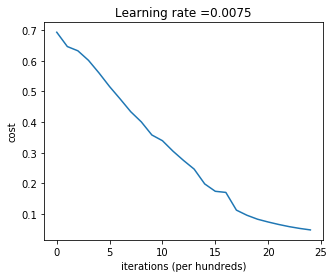

In [37]:
parameters = two_layer_model(train_set_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, show_cost = True)

In [38]:
def predict(X, parameters):
    A2, _ = L_model_forward(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

print("train accuracy: {} %".format(100 - np.mean(np.abs(predict(train_set_x, parameters) - train_set_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(predict(test_set_x, parameters) - test_set_y)) * 100))

train accuracy: 100.0 %
test accuracy: 72.0 %


We can see that the test accuracy has improved by 2% compared to the logistic regression model.

#### 2. L-layer neural network

In [47]:
layers_dims = [12288, 20, 7, 5, 1]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, show_cost=False):
    np.random.seed(1)
    costs = []                      
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if show_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
            costs.append(cost)
            
    #plot cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, show_cost = True)

print("train accuracy: {} %".format(100 - np.mean(np.abs(predict(train_set_x, parameters) - train_set_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(predict(test_set_x, parameters) - test_set_y)) * 100))

With this model, we get an accuracy of 80% on a training set, which is significantly hire than both the logistic regression and the 2-layer model.